In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import matplotlib as mpl
import warnings

from src import data, paths, centroids, matrix_filtering, communicatin_metrics, plotting, correlations

!date -I

2024-05-18


# F-TRACT per stimulated ROI

We started with replication of part of the work presented in paper *Communication dynamics in the human connectome shape the cortex-wide propagation of direct electrical stimulation* by Seguin et al. using F-TRACT dataset in [01_analysis.ipynb](./01_analysis.ipynb). Our goal here is to calculate correlation between response probability (amplitude, peak onset, peak delay) after intracranial stimulation with network communication metrics calculated on structural connectomes **per stimulated ROI**. We want to see if there is a relationship between the response and the structure combined with communication models **even if we consider only stimulation in one selected region**.

#### Settings

- `FTRACT_SHORT` True or false, if true, use responses 50 ms long, if false, use 200 ms responses. 
- `PARCELLATION` There are three sets of structural connectivity matrices in this repository based on parcellations named below. 
- `MIN_STREAMLINE` The minimal number of treamlines between two regions to consider an edge between them while creating group-averaged connectome from connectomes of individual subjects. Does not affect connectomes which were already downloaded as group average (see README in external data folder). 
- `GRAPH_DENSITY` Desired density of connectome, used for filtering of all the connectivity matrices after they are loaded.
- `ED_THRESHOLD` [mm] Region pairs closer to each other than the threshold are excludes from the analysis. We use 0 in most of our experiments, but Seguin et al. used 20 mm (they show results with 0 mm in robustness analysis in Appendix).
- `SELECTED_SC` Consider only the structural connectivity matrices from this list in the analysis. 

In [31]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION = "MNI-HCP-MMP1"

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = False

ED_THRESHOLD = 0
MIN_STREAMLINES = 5
GRAPH_DENSITY = 0.25

SELECTED_SC = ["Mica-Mics_rh"] # "Rosen-Halgren_rh"

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

- `SELECTED_ROI_(LEFT|RIGHT)` Glasser parcellation short label indicating which region we want to investigate in more detail.

Diving into the mapping of the parcellations, we found a discrepancy in the TMS-EEG data. The data describing paper by Biabani et al. declare they stimulated the primary motor cortex, which is denoted `L_4` in Glasser parcellation. Using the Dice mapping (see [XX_centroids_and_parcellations/DICE_02_glasser-schaefer200_maxdice.ipynb](../XX_centroids_and_parcellations/DICE_02_glasser-schaefer200_maxdice.ipynb)), this region has the highest overlap with ROI 7Networks_LH_SomMot_15 in Schaefer200 parcellation. However, the source-reconstruction of the TMS-EEG data by Momi et al. contains a vector indicating the stimulation weights for ROIs in Schaefer200 (see [02_pytepfit/02_stimulation-site-extraction.ipynb](../02_pytepfit/02_stimulation-site-extraction.ipynb)). According to that, the stimulation target was `7Networks_LH_SomMot_9` and `7Networks_LH_SomMot_10` was affected a bit. Using the Dice scores again, `7Networks_LH_SomMot_9` has the biggest overlap with ROI `L_1` in Glasser parcellation, followed by `L_3b`. Because of that, in is possible to set here wich ROI we want to investigate.

In [32]:
SELECTED_ROI_LEFT = "L_3b" # L_1, L_4
SELECTED_ROI_RIGHT = "R_3b" # R_1, R_4

In [33]:
fig_dir = f"ftract_results_per_roi/{'short' if FTRACT_SHORT else 'long'}/{PARCELLATION}/ED{ED_THRESHOLD}/{GRAPH_DENSITY}_density/"
%mkdir -p  {paths.path_figures(fig_dir)}

## Load data

### Load F-TRACT data

The Functional Brain Tractography project (F-TRACT) summary dataset used in this section was prepared by Jedynak et el., it consists of several matrices characterizing the brain's response to intracranial electrical stimulation.

The F-TRACT project aggregated iEEG data from 550 patients with drug-resistant epilepsy measured during $29\,055$ stimulations using 2.77 million pairs of intracerebral depth electrodes. In order to mitigate the impact of epileptogenic processes in further analyses, recordings with a high likelihood of pathological activity were excluded. The results were projected onto a number of parcellations, this notebook expects Deskian-Killiany (DKT) or Glasser (MNI-HCP-MMP1) parcellation. 

The recorded evoked potentials were baseline corrected and $z$-scored. Stimulus response was considered significant if the $z$-scored evoked potential over $z = 5$ was observed. The response amplitude was defined as the first peak of $z$-scored evoked potential above the $z = 5$ threshold. Using that, two whole-brain group-level matrices were constructed. Entries $P_{ij} \in [0,1]$ of response probability matrix $P$ characterize the probability that we observe a significant response as described above in ROI $j$ after stimulation of $i$. Entries $A_{ij} \in \mathbb{R}_{>0}$ of response amplitude matrix $A$ capture the median response amplitude of significant responses.

In [34]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, _, _, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    # following ROIs are not present in enigma with DKT parcellation,
    # so it should be deleted from responses to have matching dimensions
    ids_to_delete_in_dkt = [37,3] 

    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        response_onset_delay = np.delete(response_onset_delay,ids_to_delete_in_dkt,axis=a)
        response_peak_delay = np.delete(response_peak_delay,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

### See info about selected ROIs

In [35]:
idx_m1_l, idx_m1_r = list(ftract_labels).index("L_4"), list(ftract_labels).index("R_4") # location of primary motor cortex
idx_m1_l, idx_m1_r

(111, 291)

How many times the ROI was stimulated:

In [36]:
np.sum(n_stim[idx_m1_l]), np.sum(n_stim[idx_m1_r])

(60283.0, 46043.0)

How many implantation pairs in this ROI: 

In [37]:
np.sum(n_impl[idx_m1_l]), np.sum(n_impl[idx_m1_r])

(3347.0, 3457.0)

### Load Euclidean distances

In [38]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

### Define mask

Define which region pairs include in the analysis based on the methodology by Seguin et al.:

- probability
    - a minimum of 100 stimulation experiments
    - recordings were acquired across a minimum of 5 different patients
- amplitude
    - a minimum of 100 significant stimulation responses

In [39]:
mask = np.logical_and(np.logical_and(n_stim > 100, n_impl > 5),ED>ED_THRESHOLD)
mask_amp = (n_stim*response_probability)>=100

Text(0.5, 1.0, 'Amplitude mask: (n_stim*P)>100')

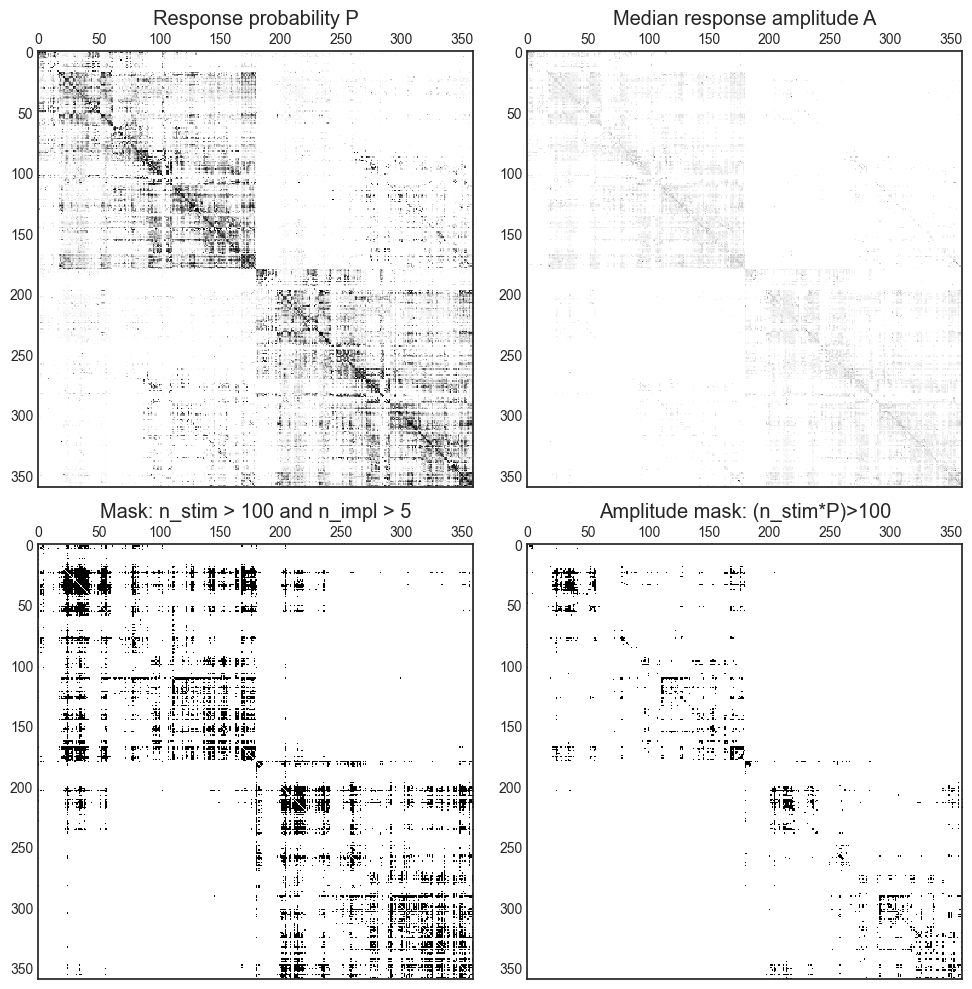

In [40]:
plt.style.use('seaborn-v0_8-white')
fig, axs = plt.subplots(2, 2, figsize=(10,10),tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)
axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural connectivity data

Load structural connectivity data based on parcellation. `SC_matrices` is a list of tuples `(str, 2D np.array, 2D np.array, 2D np.array)` consisting of: 
- name in a form [dataset]_[group averaging method]
- structural connectivity weights
- structural connectivity lengths
- logarithm of structural connectivity weights

Group averaging method is a string indicating how the group representative connectome was created, options are:
- `simple` simple averaging
- `cons` consensus thresholding
- `dist` distance-dependent consensus thresholding
- `rh` Rosen and Halgren's method

In [41]:
SC_matrices = []

if PARCELLATION == "DKT":
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=MIN_STREAMLINES)
    

elif PARCELLATION == "MNI-HCP-MMP1":
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED,min_streamlines_count=MIN_STREAMLINES)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [42]:
SC_matrices = matrix_filtering.filter_matrices_based_on_density(SC_matrices,GRAPH_DENSITY)

## Prepare dataframes

For each dataset and response characteristic (probability, amplitude, onset delay and peak delay), create a multiindex dataframe with columns corresponding to Euclidean distance, structural connectivity and communication metrics and rows corresponding to ROIs where we observe the response (second level of index) based on stimulated ROI (first level of index).

|column name | description |
|---|---|
| ED    | Euclidean distance
| SC_W   | structural connectivity - weights
| SC_L   | structural connectivity - lengths
| SPE   | shortest path efficiency
| SPE_W | shortest path efficiency with 1/SC_W instead of SC_L 
| COM   | communicability
| SI    | search information
| SI_L  | search information with SC_L for path length
| NAV   | navigation efficiency
| DIF   | diffusion efficiency

In [43]:
def df_per_roi(response,mask,metrics_dict,ftract_labels):
    """
    Create multiindex dataframe, first level corresponds to stimulated 
    ROI name, second level to responsing ROI (ids, not names).
    """

    masked_response = np.where(mask,response,np.nan)

    temp = dict()
    for roi,label in enumerate(ftract_labels):
        df_per_roi = pd.DataFrame()
        response_per_roi = masked_response[roi,:]
        if np.isnan(response_per_roi).all():
            continue
        df_per_roi["response"] = pd.Series(response_per_roi)
        for m in metrics_dict:
            m_masked = metrics_dict[m]
            df_per_roi[m] = pd.Series(m_masked[roi,:])

        temp[label] = df_per_roi
    
    df = pd.concat(temp)
        
    return df

In [44]:
stat_data_per_roi = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if name not in SELECTED_SC:
        continue

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

    df_probability = df_per_roi(response_probability,mask,metrics_dict,ftract_labels)
    df_amplitude = df_per_roi(response_amplitude,mask_amp,metrics_dict,ftract_labels)

    if name == SELECTED_SC[0]:
        display(df_probability)
        
    stat_data_per_roi[name] = {"probability":df_probability,"amplitude":df_amplitude}

response         ED      SC_W       SC_L       SPE     SPE_W  \
L_V1 0         NaN   0.000000  0.000000   0.000000       inf       inf   
     1       0.665  32.704258  0.014682  30.008840  0.033324  0.014682   
     2       0.502   4.387056  0.231330  17.996940  0.055565  0.231330   
     3       0.342   9.158334  0.117899  24.835140  0.040266  0.117899   
     4       0.559  20.061667  0.045920  26.948800  0.037107  0.050682   
...            ...        ...       ...        ...       ...       ...   
R_PI 355       NaN  28.904230  0.000000        inf  0.021966  0.004822   
     356       NaN  13.993189  0.009525  18.143880  0.055115  0.009525   
     357       NaN  31.648382  0.000366  53.794255  0.023179  0.005911   
     358       NaN  35.875564  0.000556  61.398875  0.018878  0.006103   
     359       NaN   0.000000  0.000000   0.000000       inf       inf   

               COM        SI       SI_L       NAV       DIF  
L_V1 0    0.000000       NaN        NaN       inf  0.000000  
     1    0.050863  5.422890   5.422890  0.033324  0.002267  
     2    0.439617  1.445018   1.445018  0.055565  0.005008  
     3    0.255543  2.417416   2.417416  0.040266  0.004789  
     4    0.121605  3.777788   3.777788  0.037107  0.004180  
...            ...       ...        ...       ...       ...  
R_PI 355  0.000903       inf  11.701398  0.014289  0.001697  
     356  0.031460  5.174274   5.174274  0.055115  0.002962  
     357  0.003970  9.876495  11.801600  0.018589  0.001188  
     358  0.003705  9.273485  10.336775  0.016287  0.001313  
     359  0.000000       NaN        NaN       inf  0.000000  

[114120 rows x 11 columns]

## Correlations per stimulated ROI

Calculate correlations per stimulated ROI and plot aggregated results.

In [45]:
keys = []

result_p_per_roi = []
result_p_partial_per_roi = []


for name in SELECTED_SC:
    print(name)
    keys.append(name)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        # supress warnings about small number of examples (it returns nans if sample size is too small, which is ok in this case)
        r = correlations.corr_per_roi(stat_data_per_roi[name]["probability"]).round(3)
        partial_r = correlations.partial_corr_per_roi(stat_data_per_roi[name]["probability"])
        for x in [r,partial_r]:
            correlations.abs_r_to_dataframe(x)
            correlations.sigf_sign_to_dataframe(x)   
            correlations.sigf_num_to_dataframe(x)
            correlations.r_only_sigf_to_dataframe(x)
        
        result_p_per_roi.append(r)
        result_p_partial_per_roi.append(partial_r)

Mica-Mics_rh


In [46]:
result_p_per_roi = pd.concat(result_p_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])
result_p_partial_per_roi = pd.concat(result_p_partial_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])

In [47]:
result_p_per_roi

,dataset,roi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs,p_sigf,p_sigf_num,r_sigf
0,Mica-Mics_rh,R_a24pr,0,response,ED,spearman,two-sided,8,-0.405,"[-0.86, 0.42]",0.320,0.174,0.405,,0,NaN
1,Mica-Mics_rh,R_a24pr,1,response,SC_W,spearman,two-sided,8,0.317,"[-0.5, 0.84]",0.444,0.121,0.317,,0,NaN
2,Mica-Mics_rh,R_a24pr,2,response,SC_L,spearman,two-sided,8,-0.342,"[-0.84, 0.48]",0.408,0.134,0.342,,0,NaN
3,Mica-Mics_rh,R_a24pr,3,response,SPE,spearman,two-sided,8,0.405,"[-0.42, 0.86]",0.320,0.174,0.405,,0,NaN
4,Mica-Mics_rh,R_a24pr,4,response,SPE_W,spearman,two-sided,8,0.095,"[-0.65, 0.75]",0.823,0.055,0.095,,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,Mica-Mics_rh,L_A1,5,response,COM,spearman,two-sided,16,0.618,"[0.18, 0.85]",0.011,0.760,0.618,*,1,0.618
3006,Mica-Mics_rh,L_A1,6,response,SI,spearman,two-sided,16,-0.443,"[-0.77, 0.07]",0.085,0.422,0.443,,0,NaN
3007,Mica-Mics_rh,L_A1,7,response,SI_L,spearman,two-sided,16,-0.559,"[-0.83, -0.09]",0.024,0.646,0.559,*,1,-0.559
3008,Mica-Mics_rh,L_A1,8,response,NAV,spearman,two-sided,16,0.674,"[0.27, 0.88]",0.004,0.855,0.674,*,1,0.674


In [48]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42','#FBC15E', '#777777', '#988ED5', '#FFB5B8']) 

The following tables show mean correlation, number of significant correlations and mean number of not-nan values for per-ROI analysis of the dataset and communication metric (Y).

In [49]:
for rpr in [result_p_per_roi,result_p_partial_per_roi]:#,result_a_per_roi,result_a_partial_per_roi]:
    display(rpr.groupby(by=["dataset","Y"])[['r','p_sigf_num','n']].agg({'r':'mean','p_sigf_num':'sum','n':'mean'}))

r  p_sigf_num          n
dataset      Y                                     
Mica-Mics_rh COM    0.651761         224  33.790698
             DIF    0.160561          18  33.790698
             ED    -0.689070         237  33.790698
             NAV    0.690894         240  33.790698
             SC_L  -0.645098         233  33.790698
             SC_W   0.602515         221  33.790698
             SI    -0.602515         221  33.790698
             SI_L  -0.626153         224  33.790698
             SPE    0.708086         241  33.790698
             SPE_W  0.637193         219  33.790698

r  p_sigf_num          n
dataset      Y                                     
Mica-Mics_rh COM    0.332913         144  36.545126
             DIF    0.094823          34  36.545126
             ED     0.000000           0   0.000000
             NAV    0.345343         157  36.545126
             SC_L  -0.318744         141  36.545126
             SC_W   0.297404         135  36.545126
             SI    -0.297404         135  36.545126
             SI_L  -0.315668         128  36.545126
             SPE    0.342051         152  36.545126
             SPE_W  0.337235         141  36.545126

The results do not plot absolute values of correlations this time because it might happen that the correlation is positive for some ROI and negative for other and we do not want to remove this.

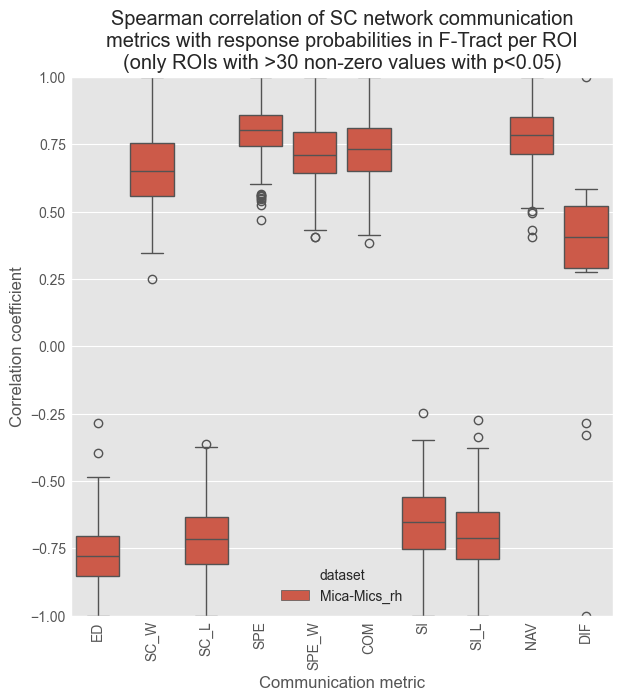

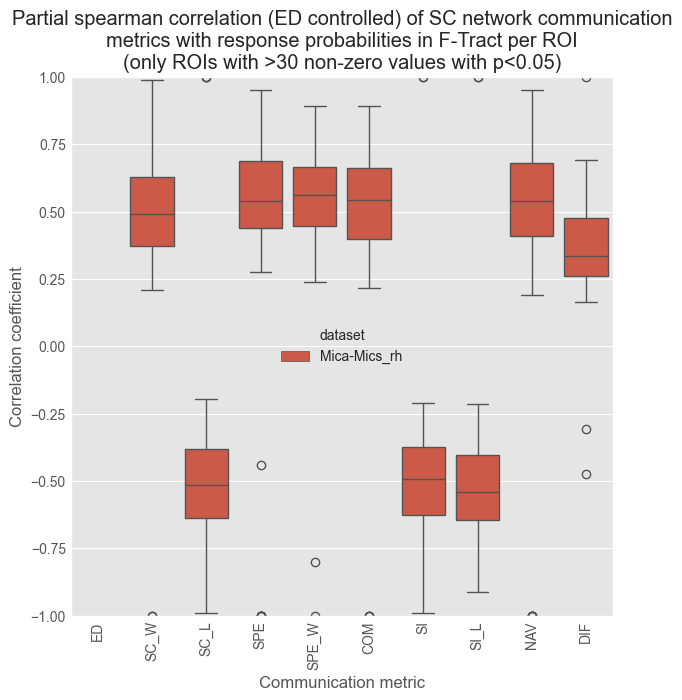

In [50]:
plotting.plot_results_per_roi(result_p_per_roi,fig_dir,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")
plotting.plot_results_per_roi(result_p_partial_per_roi,fig_dir,title="Partial spearman correlation (ED controlled) of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")

## Specific ROI

Select specific stimulated ROI (both for left and right hemisphere) and ignore the rest of the data, looking just if there are correlations of the response probabilities with structural connectivity and communication metrics when we cosider just this ROI. The results for left and right hemisphere might differe because tthe hemispheres are not entirely symmetric and there are not the same number of measurements.

In [51]:
stat_m = {}
stat_m_partial = {}

for name in SELECTED_SC:

    dict_rl = {}
    dict_rl_partial = {}

    for i,ROI in [("L_hemi",SELECTED_ROI_LEFT),("R_hemi",SELECTED_ROI_RIGHT)]:
        selected_roi_data = stat_data_per_roi[name]["probability"].loc[SELECTED_ROI_LEFT]
        print("L",np.count_nonzero(selected_roi_data))
        stat_roi = pg.pairwise_corr(selected_roi_data,'response', method='spearman').round(3)
        stat_roi_partial = correlations.partial_corr_ED(selected_roi_data,'response', method='spearman').round(3)
        dict_rl[i] = stat_roi
        dict_rl_partial[i] = stat_roi_partial

    for d,s in [(dict_rl,stat_m),(dict_rl_partial,stat_m_partial)]:
        stat = pd.concat(d)
        stat = stat.reset_index(names=["hemi",'-'])
        correlations.abs_r_to_dataframe(stat)
        correlations.sigf_sign_to_dataframe(stat)
        s[name] = stat

stat_m_df = pd.concat(stat_m).reset_index(names=["dataset",'--'])
stat_m_df_partial = pd.concat(stat_m_partial).reset_index(names=["dataset",'--'])

stat_m_df

L 3688
L 3688


,dataset,--,hemi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs,p_sigf
0,Mica-Mics_rh,0,L_hemi,0,response,ED,spearman,two-sided,78,-0.725,"[-0.82, -0.6]",0.00,1.00,0.725,*
1,Mica-Mics_rh,1,L_hemi,1,response,SC_W,spearman,two-sided,78,0.698,"[0.56, 0.8]",0.00,1.00,0.698,*
2,Mica-Mics_rh,2,L_hemi,2,response,SC_L,spearman,two-sided,78,-0.760,"[-0.84, -0.65]",0.00,1.00,0.760,*
3,Mica-Mics_rh,3,L_hemi,3,response,SPE,spearman,two-sided,78,0.803,"[0.71, 0.87]",0.00,1.00,0.803,*
4,Mica-Mics_rh,4,L_hemi,4,response,SPE_W,spearman,two-sided,78,0.705,"[0.57, 0.8]",0.00,1.00,0.705,*
5,Mica-Mics_rh,5,L_hemi,5,response,COM,spearman,two-sided,78,0.764,"[0.65, 0.84]",0.00,1.00,0.764,*
6,Mica-Mics_rh,6,L_hemi,6,response,SI,spearman,two-sided,78,-0.698,"[-0.8, -0.56]",0.00,1.00,0.698,*
7,Mica-Mics_rh,7,L_hemi,7,response,SI_L,spearman,two-sided,78,-0.632,"[-0.75, -0.48]",0.00,1.00,0.632,*
8,Mica-Mics_rh,8,L_hemi,8,response,NAV,spearman,two-sided,78,0.774,"[0.67, 0.85]",0.00,1.00,0.774,*
9,Mica-Mics_rh,9,L_hemi,9,response,DIF,spearman,two-sided,78,0.047,"[-0.18, 0.27]",0.68,0.07,0.047,


In [52]:
stat_m_df_partial

,dataset,--,hemi,-,n,r,CI95%,p-val,Y,r_abs,p_sigf
0,Mica-Mics_rh,0,L_hemi,0,0,0.000,None,1.000,ED,0.000,
1,Mica-Mics_rh,1,L_hemi,spearman,78,0.364,"[0.15, 0.54]",0.001,SC_W,0.364,*
2,Mica-Mics_rh,2,L_hemi,spearman,78,-0.422,"[-0.59, -0.22]",0.000,SC_L,0.422,*
3,Mica-Mics_rh,3,L_hemi,spearman,78,0.503,"[0.31, 0.65]",0.000,SPE,0.503,*
4,Mica-Mics_rh,4,L_hemi,spearman,78,0.293,"[0.07, 0.49]",0.010,SPE_W,0.293,*
5,Mica-Mics_rh,5,L_hemi,spearman,78,0.448,"[0.25, 0.61]",0.000,COM,0.448,*
6,Mica-Mics_rh,6,L_hemi,spearman,78,-0.364,"[-0.54, -0.15]",0.001,SI,0.364,*
7,Mica-Mics_rh,7,L_hemi,spearman,78,-0.175,"[-0.38, 0.05]",0.128,SI_L,0.175,
8,Mica-Mics_rh,8,L_hemi,spearman,78,0.436,"[0.24, 0.6]",0.000,NAV,0.436,*
9,Mica-Mics_rh,9,L_hemi,spearman,78,-0.085,"[-0.3, 0.14]",0.463,DIF,0.085,


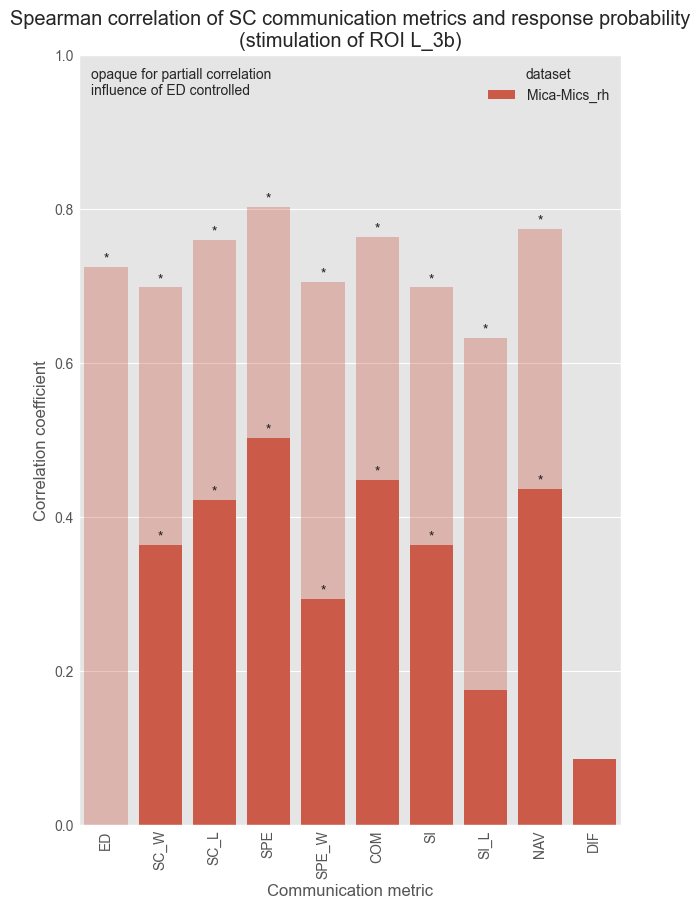

In [53]:
df_lhemim1 = stat_m_df[stat_m_df.hemi=="L_hemi"].copy()
df_lhemim1_partial = stat_m_df_partial[stat_m_df_partial.hemi=="L_hemi"].copy()

title=f"Spearman correlation of SC communication metrics and response probability\n(stimulation of ROI {SELECTED_ROI_LEFT})"
plotting.plot_results_overlay(df_lhemim1,df_lhemim1_partial,title=title,fig_dir=fig_dir)

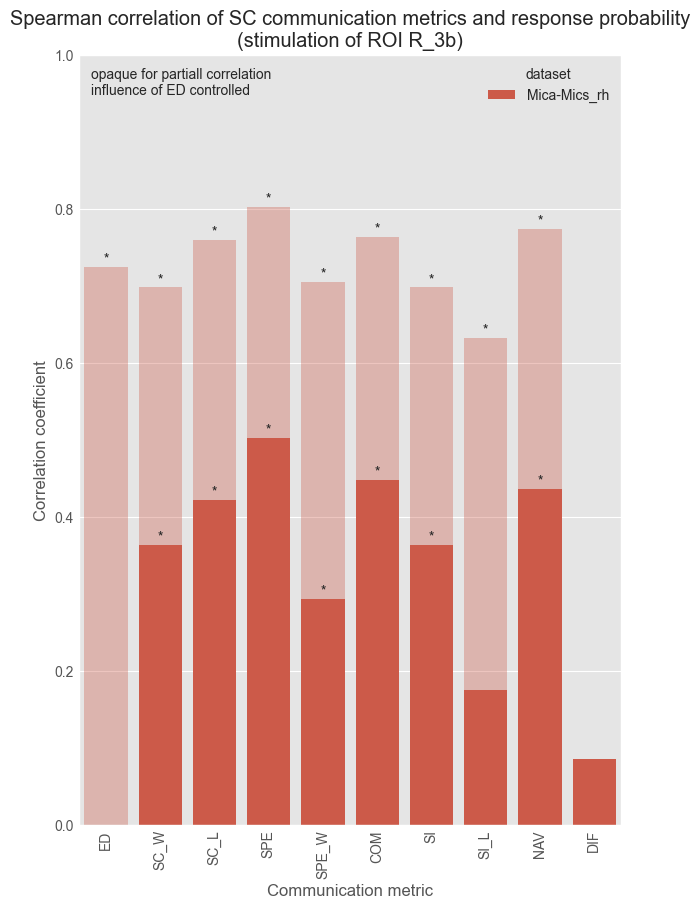

In [54]:
df_rhemim1 = stat_m_df[stat_m_df.hemi=="R_hemi"].copy()
df_rhemim1_partial = stat_m_df_partial[stat_m_df_partial.hemi=="R_hemi"].copy()

title=f"Spearman correlation of SC communication metrics and response probability\n(stimulation of ROI {SELECTED_ROI_RIGHT})"
plotting.plot_results_overlay(df_rhemim1,df_rhemim1_partial,title=title,fig_dir=fig_dir)

In [55]:
selected_roi_data = selected_roi_data.copy()
selected_roi_data["label"] = ftract_labels
selected_roi_data = selected_roi_data.set_index("label")
selected_roi_data

,response,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
label,,,,,,,,,,,
L_V1,NaN,86.130607,0.0,inf,0.009180,0.004199,0.000142,inf,18.968501,0.005998,0.002778
L_V6,NaN,66.905377,0.0,inf,0.009451,0.005002,0.000193,inf,14.131162,0.008234,0.001962
L_V2,NaN,81.759962,0.0,inf,0.009236,0.004157,0.000104,inf,18.859902,0.006358,0.002463
L_V3,NaN,81.100872,0.0,inf,0.008173,0.004355,0.000131,inf,14.547486,0.007004,0.002766
L_V4,NaN,82.487126,0.0,inf,0.008430,0.004579,0.000099,inf,21.530236,0.007316,0.002854
...,...,...,...,...,...,...,...,...,...,...,...
R_FOP2,NaN,90.352537,0.0,inf,0.007381,0.005861,0.000228,inf,22.657491,0.006939,0.001658
R_PoI1,NaN,95.853057,0.0,inf,0.007615,0.004942,0.000635,inf,15.317664,0.006197,0.002664
R_Ig,NaN,83.897695,0.0,inf,0.007489,0.005057,0.000240,inf,21.995380,0.006711,0.001151


## Save data for one ROI

Save data for one ROI for further analysis in `03_compare_f-tract_pytepfit`.

In [56]:
selected_roi_data.to_csv(paths.path(f"interim/{SELECTED_ROI_LEFT}_response_probability_and_communication_metrics_M1_FTRACT_ED{ED_THRESHOLD}_{'short' if FTRACT_SHORT else 'long'}.csv"))

In [57]:
relevant = selected_roi_data[selected_roi_data["response"].notnull()]
relevant

,response,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
label,,,,,,,,,,,
L_RI,0.364,34.951378,0.000400,61.529380,0.016252,0.008555,0.004370,10.208610,10.208610,0.016252,0.002178
L_PFcm,0.373,34.991469,0.000708,68.006760,0.016297,0.009289,0.005639,9.385681,13.124912,0.014704,0.001891
L_TA2,0.009,66.802986,0.000000,inf,0.010720,0.005825,0.000321,inf,15.648536,0.005698,0.001576
L_PreS,0.037,66.681408,0.000490,88.852489,0.011548,0.005732,0.001563,9.915741,13.487364,0.011255,0.002136
L_H,0.033,69.696386,0.000000,inf,0.009738,0.005168,0.000077,inf,19.327842,0.009058,0.000557
...,...,...,...,...,...,...,...,...,...,...,...
L_FOP3,0.420,47.070841,0.000879,66.579360,0.015107,0.006939,0.005954,9.072624,12.507368,0.015020,0.001438
L_FOP2,0.367,42.175982,0.000812,60.332400,0.020131,0.010220,0.007485,9.186725,10.928498,0.016575,0.001679
L_PoI1,0.272,55.998537,0.004469,64.064020,0.015609,0.007514,0.015145,6.726751,6.726751,0.015609,0.002768


In [58]:
len(relevant)

78